In [ ]:
pip install torch torchvision opencv-python pillow tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hojjatk/mnist-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'mnist-dataset' dataset.
Path to dataset files: /kaggle/input/mnist-dataset


In [ ]:
import numpy as np
import struct

def read_idx_images_np(images_path):
    with open(images_path, "rb") as f:
        magic, size, rows, cols = struct.unpack(">IIII", f.read(16))
        assert magic == 2051, f"Bad image magic: {magic}"
        data = np.frombuffer(f.read(), dtype=np.uint8)
        return data.reshape(size, rows, cols)

def read_idx_labels_np(labels_path):
    with open(labels_path, "rb") as f:
        magic, size = struct.unpack(">II", f.read(8))
        assert magic == 2049, f"Bad label magic: {magic}"
        return np.frombuffer(f.read(), dtype=np.uint8)

In [ ]:
from os.path import join
training_images_filepath = join(path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath     = join(path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath     = join(path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

x_train = read_idx_images_np(training_images_filepath)
y_train = read_idx_labels_np(training_labels_filepath)
x_test  = read_idx_images_np(test_images_filepath)
y_test  = read_idx_labels_np(test_labels_filepath)

x_train = np.ascontiguousarray(x_train, dtype=np.uint8)
x_test  = np.ascontiguousarray(x_test,  dtype=np.uint8)
y_train = np.ascontiguousarray(y_train, dtype=np.uint8)
y_test  = np.ascontiguousarray(y_test,  dtype=np.uint8)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [ ]:
from pathlib import Path
import cv2 as cv
from tqdm import tqdm
import csv
import shutil
import random

PNG_FAST = [cv.IMWRITE_PNG_COMPRESSION, 1]

LOCAL_ROOT = Path("/content/ee604")
LOCAL_ROOT.mkdir(parents=True, exist_ok=True)
DRIVE_ROOT = Path("/content/drive/MyDrive/ee604")

def otsu_mask_fast(img_u8: np.ndarray) -> np.ndarray:
    _, m = cv.threshold(img_u8, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    return m

masks_train = np.stack([otsu_mask_fast(x) for x in tqdm(x_train, desc="Otsu train")], axis=0)
masks_test  = np.stack([otsu_mask_fast(x) for x in tqdm(x_test,  desc="Otsu test")],  axis=0)

Otsu test: 100%|██████████| 10000/10000 [00:00<00:00, 180743.78it/s]


In [ ]:
Q1A_ROOT  = LOCAL_ROOT / "q1a_pairs"
TRAIN_OUT = Q1A_ROOT / "train"; TRAIN_OUT.mkdir(parents=True, exist_ok=True)
TEST_OUT  = Q1A_ROOT / "test";  TEST_OUT.mkdir(parents=True, exist_ok=True)

def write_pairs(xs, msks, out_dir: Path, desc: str):
    for i in tqdm(range(len(xs)), desc=desc):
        cv.imwrite(str(out_dir / f"{i:06d}_img.png"),  xs[i],   PNG_FAST)
        cv.imwrite(str(out_dir / f"{i:06d}_mask.png"), msks[i], PNG_FAST)

write_pairs(x_train, masks_train, TRAIN_OUT, "Q1(a) train")
write_pairs(x_test,  masks_test,  TEST_OUT,  "Q1(a) test")
print("Q1(a) saved at:", Q1A_ROOT)

Q1(a) test: 100%|██████████| 10000/10000 [00:02<00:00, 4784.92it/s]

Q1(a) saved at: /content/ee604/q1a_pairs


In [ ]:
from pathlib import Path
import cv2 as cv
import numpy as np
from tqdm import tqdm
import csv

Q1B_ROOT  = LOCAL_ROOT / "q1b_pairs"
Q1B_TRAIN = Q1B_ROOT / "train"; Q1B_TRAIN.mkdir(parents=True, exist_ok=True)
Q1B_TEST  = Q1B_ROOT / "test";  Q1B_TEST.mkdir(parents=True, exist_ok=True)

def circle_from_binary(binary: np.ndarray) -> np.ndarray:
    cnts, _ = cv.findContours((binary>0).astype(np.uint8), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return np.zeros_like(binary)
    c = max(cnts, key=cv.contourArea)
    (cx, cy), r = cv.minEnclosingCircle(c)
    out = np.zeros_like(binary)
    cv.circle(out, (int(round(cx)), int(round(cy))), int(np.ceil(r)), 255, -1, lineType=cv.LINE_AA)
    return out

def build_q1b(x_arr, m_arr, y_arr, out_dir: Path, desc: str):
    manifest = [("img_path","circle_mask_path","label")]
    N = len(x_arr)
    for i in tqdm(range(N), desc=desc):
        cm = circle_from_binary(m_arr[i])
        p_img  = out_dir / f"{i:06d}_img.png"
        p_cmsk = out_dir / f"{i:06d}_circle.png"
        cv.imwrite(str(p_img),  x_arr[i], PNG_FAST)
        cv.imwrite(str(p_cmsk), cm,       PNG_FAST)
        manifest.append((str(p_img), str(p_cmsk), int(y_arr[i])))
    import csv
    with open(out_dir / "manifest.csv", "w", newline="") as f:
        csv.writer(f).writerows(manifest)

build_q1b(x_train, masks_train, y_train, Q1B_TRAIN, "Q1(b) train")
build_q1b(x_test,  masks_test,  y_test,  Q1B_TEST,  "Q1(b) test")
print("Q1(b) saved at:", Q1B_ROOT)


Q1(b) test: 100%|██████████| 10000/10000 [00:02<00:00, 3360.34it/s]

Q1(b) saved at: /content/ee604/q1b_pairs


In [ ]:
Q1C_ROOT  = LOCAL_ROOT / "q1c_semseg"
Q1C_TRAIN = Q1C_ROOT / "train"; (Q1C_TRAIN / "images").mkdir(parents=True, exist_ok=True); (Q1C_TRAIN / "labels").mkdir(parents=True, exist_ok=True)
Q1C_TEST  = Q1C_ROOT / "test";  (Q1C_TEST / "images").mkdir(parents=True, exist_ok=True);  (Q1C_TEST / "labels").mkdir(parents=True, exist_ok=True)

def compose_2x2_from_arrays(indices, X, M, Y):
    comp = np.zeros((56,56), np.uint8)
    lab  = np.full((56,56), 255, np.uint8)
    coords = [(0,0),(0,28),(28,0),(28,28)]
    for k, idx in enumerate(indices):
        r0,c0 = coords[k]
        comp[r0:r0+28, c0:c0+28] = X[idx]
        lab[r0:r0+28, c0:c0+28][M[idx]>0] = int(Y[idx])
    return comp, lab

def build_q1c(X, M, Y, out_dir: Path, total: int, seed: int, desc: str):
    N = len(Y)
    rng = np.random.default_rng(seed)
    seen = set()
    for i in tqdm(range(total), desc=desc):
        # sample unique ordered 4-tuple
        while True:
            quad = tuple(rng.integers(0, N, size=4).tolist())
            if quad not in seen:
                seen.add(quad); break
        comp, lab = compose_2x2_from_arrays(quad, X, M, Y)
        fn = f"{i:07d}.png"
        cv.imwrite(str((out_dir / "images" / fn)), comp, PNG_FAST)
        cv.imwrite(str((out_dir / "labels" / fn)), lab,  PNG_FAST)

N_TRAIN = 250_000
N_TEST  = 10_000
build_q1c(x_train, masks_train, y_train, Q1C_TRAIN, N_TRAIN, seed=12345, desc=f"Q1(c) TRAIN {N_TRAIN}")
build_q1c(x_test,  masks_test,  y_test,  Q1C_TEST,  N_TEST,  seed=2025,  desc=f"Q1(c) TEST  {N_TEST}")
print("Q1(c) saved at:", Q1C_ROOT)


Q1(c) TEST  10000: 100%|██████████| 10000/10000 [00:06<00:00, 1535.77it/s]

Q1(c) saved at: /content/ee604/q1c_semseg


In [ ]:
from zipfile import ZipFile, ZIP_STORED
import os
ZIP_PATH = Path("/content/ee604_datasets.zip")
print(f"Zipping from: {LOCAL_ROOT}")
files = []
for root, _, fnames in os.walk(LOCAL_ROOT):
    for fn in fnames:
        full = Path(root) / fn
        arc  = full.relative_to(LOCAL_ROOT.parent)  # keep ee604/... inside zip
        files.append((full, arc))

with ZipFile(ZIP_PATH, mode="w", compression=ZIP_STORED) as z, \
     tqdm(total=len(files), desc="Creating zip (files)", unit="file") as pbar:
    for full, arc in files:
        z.write(full, arcname=str(arc)); pbar.update(1)

size_mb = ZIP_PATH.stat().st_size / (1024*1024)
print(f"Zip created: {ZIP_PATH} ({size_mb:.2f} MB)")

def copy_with_progress(src: Path, dst: Path, desc="Uploading zip to Drive", chunk=1024*1024):
    total = src.stat().st_size
    dst.parent.mkdir(parents=True, exist_ok=True)
    with tqdm(total=total, unit="B", unit_scale=True, desc=desc) as pbar, \
         open(src, "rb") as fsrc, open(dst, "wb") as fdst:
        while True:
            buf = fsrc.read(chunk)
            if not buf: break
            fdst.write(buf); pbar.update(len(buf))

target_zip = DRIVE_ROOT / ZIP_PATH.name
copy_with_progress(ZIP_PATH, target_zip)
print("Zip uploaded to:", target_zip)

Zipping from: /content/ee604


Creating zip (files): 100%|██████████| 800002/800002 [02:56<00:00, 4530.14file/s]


Zip created: /content/ee604_datasets.zip (533.16 MB)


Uploading zip to Drive: 100%|██████████| 559M/559M [00:01<00:00, 281MB/s]

Zip uploaded to: /content/drive/MyDrive/ee604/ee604_datasets.zip


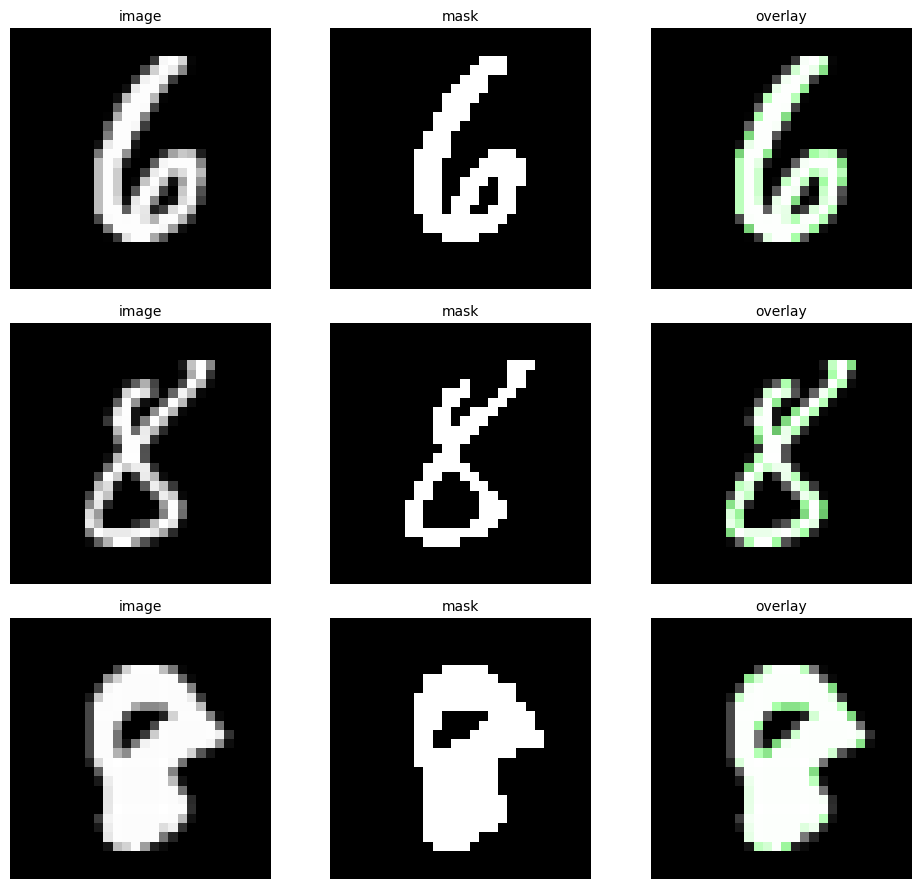

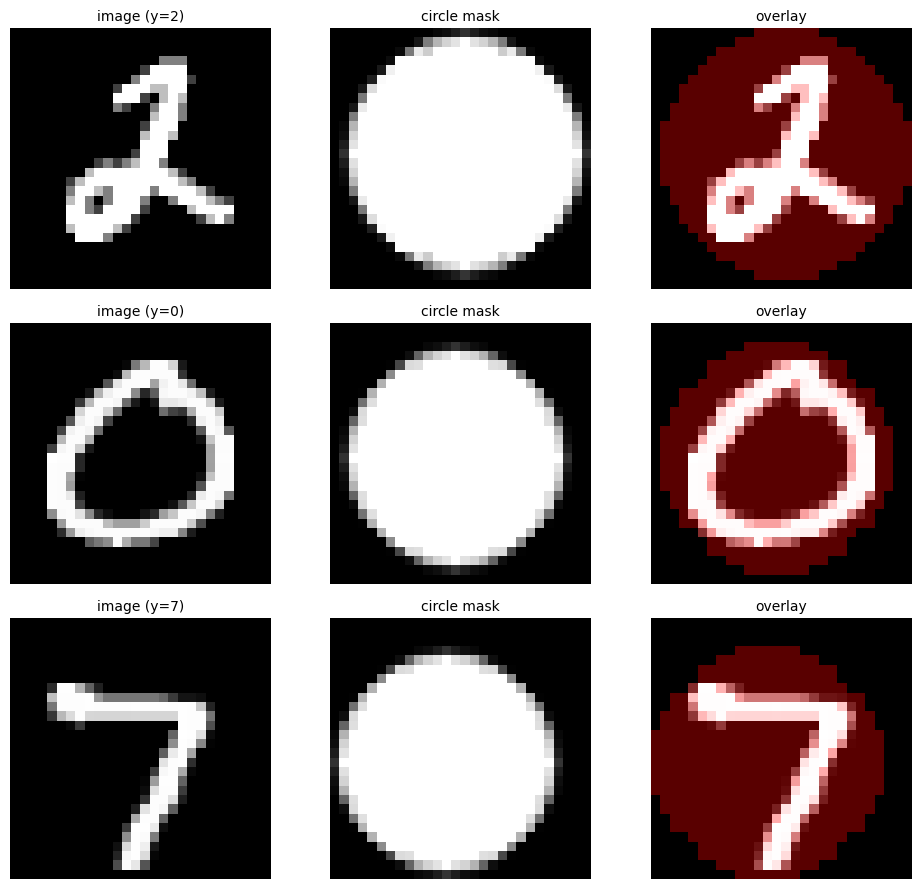

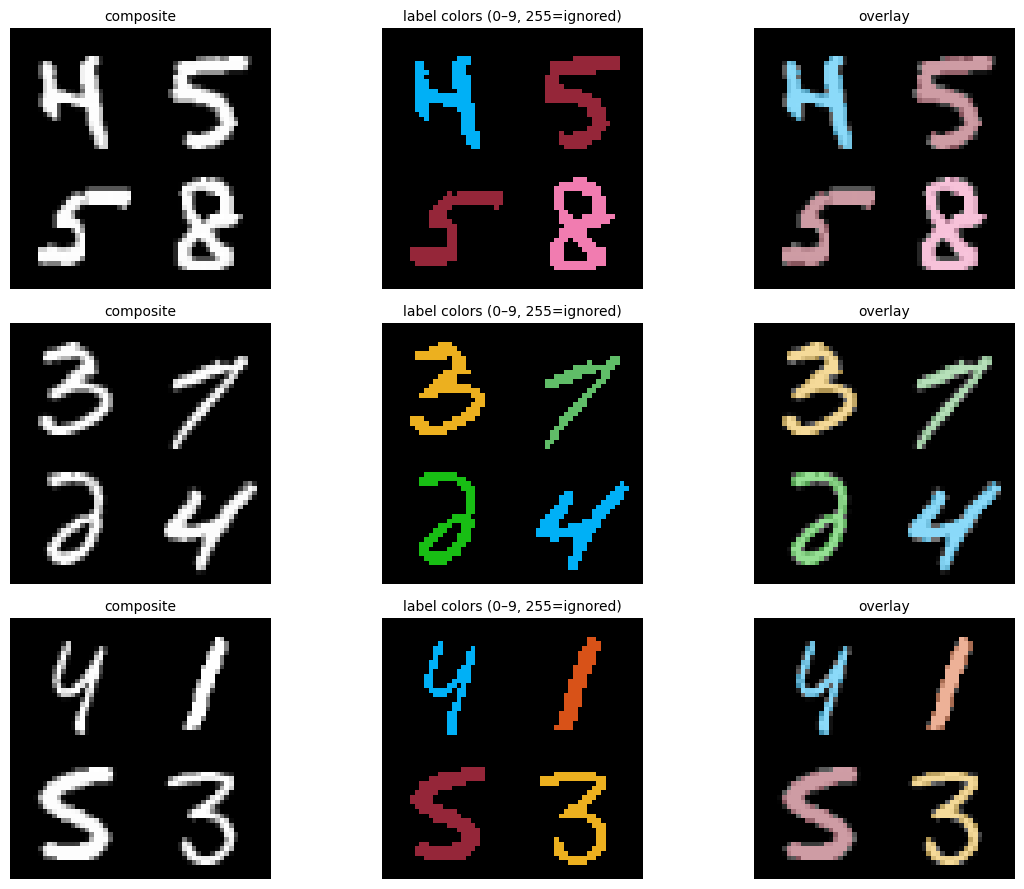

In [ ]:
# ======================
# Visualize Q1(a), Q1(b), Q1(c)
# ======================
from pathlib import Path
import random, csv, math
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# ---- roots (auto-pick local if present, else Drive) ----
LOCAL_ROOT = Path("/content/ee604")
DRIVE_ROOT = Path("/content/drive/MyDrive/ee604")
ROOT = LOCAL_ROOT if LOCAL_ROOT.exists() else DRIVE_ROOT

Q1A_ROOT = ROOT / "q1a_pairs"
Q1B_ROOT = ROOT / "q1b_pairs"
Q1C_ROOT = ROOT / "q1c_semseg"

# ---- helpers ----
def _ensure_exists(p: Path):
    if not p.exists():
        raise FileNotFoundError(f"Not found: {p}")

def _to_rgb(img_gray: np.ndarray) -> np.ndarray:
    """28x28 or 56x56 uint8 gray -> RGB uint8"""
    return cv.cvtColor(img_gray, cv.COLOR_GRAY2RGB)

def _overlay(img_gray: np.ndarray, mask_bin: np.ndarray, color=(255,0,0), alpha=0.35):
    """Overlay a binary mask (0/255) on grayscale image."""
    base = _to_rgb(img_gray)
    color_layer = np.zeros_like(base)
    color_layer[mask_bin > 0] = color  # fill color where mask==255
    out = cv.addWeighted(base, 1.0, color_layer, alpha, 0)
    return out

# fixed palette for digits 0..9
PALETTE = np.array([
    [  0, 113, 188],  # 0
    [216,  82,  24],  # 1
    [ 24, 190,  20],  # 2
    [236, 176,  31],  # 3
    [  0, 176, 246],  # 4
    [149,  38,  57],  # 5
    [ 96,  74, 123],  # 6
    [ 96, 189, 104],  # 7
    [241, 124, 176],  # 8
    [178, 145,  47],  # 9
], dtype=np.uint8)

def colorize_labels(lbl: np.ndarray) -> np.ndarray:
    """
    lbl: uint8 (H,W) with {0..9, 255}
    returns RGB uint8 where 255 stays transparent color (black).
    """
    h, w = lbl.shape
    rgb = np.zeros((h,w,3), dtype=np.uint8)
    mask_ignore = (lbl == 255)
    # map classes
    for c in range(10):
        rgb[lbl == c] = PALETTE[c]
    rgb[mask_ignore] = [0,0,0]
    return rgb

def overlay_labels(img_gray: np.ndarray, lbl: np.ndarray, alpha=0.35):
    base = _to_rgb(img_gray)
    color = colorize_labels(lbl)
    # build per-pixel alpha: 0 for ignore(255), 'alpha' otherwise
    a = np.where(lbl == 255, 0.0, alpha).astype(np.float32)[..., None]
    over = (base.astype(np.float32)*(1-a) + color.astype(np.float32)*a).astype(np.uint8)
    return over

def show_grid(images, titles=None, cols=3, figsize=(12,8)):
    rows = math.ceil(len(images)/cols)
    plt.figure(figsize=figsize)
    for i, im in enumerate(images):
        ax = plt.subplot(rows, cols, i+1)
        if im.ndim == 2:
            ax.imshow(im, cmap='gray', vmin=0, vmax=255)
        else:
            ax.imshow(im)
        ax.axis('off')
        if titles and i < len(titles): ax.set_title(titles[i], fontsize=10)
    plt.tight_layout(); plt.show()

# ---- Q1(a) ----
def viz_q1a(split="train", k=6):
    base = Q1A_ROOT / split
    _ensure_exists(base)
    imgs = sorted(base.glob("*_img.png"))
    if len(imgs) == 0: raise RuntimeError(f"No images in {base}")
    picks = random.sample(imgs, k=min(k, len(imgs)))
    out = []
    titles = []
    for p in picks:
        stem = p.stem.replace("_img","")
        m = base / f"{stem}_mask.png"
        im = cv.imread(str(p), cv.IMREAD_GRAYSCALE)
        mk = cv.imread(str(m), cv.IMREAD_GRAYSCALE)
        out += [im, mk, _overlay(im, mk, color=(0,255,0), alpha=0.35)]
        titles += ["image", "mask", "overlay"]
    show_grid(out, titles, cols=3, figsize=(10, 3*math.ceil(len(out)/3)))

# ---- Q1(b) ----
def viz_q1b(split="train", k=6):
    base = Q1B_ROOT / split
    _ensure_exists(base)
    man = base / "manifest.csv"
    if not man.exists(): raise FileNotFoundError(f"manifest.csv missing in {base}")
    rows = []
    with open(man, newline="") as f:
        r = csv.reader(f)
        header = next(r, None)  # img_path, circle_mask_path, label
        rows = list(r)
    picks = random.sample(rows, k=min(k, len(rows)))
    out, titles = [], []
    for (p_img, p_cmsk, lbl) in picks:
        im = cv.imread(p_img, cv.IMREAD_GRAYSCALE)
        cm = cv.imread(p_cmsk, cv.IMREAD_GRAYSCALE)
        over = _overlay(im, cm, color=(255,0,0), alpha=0.35)
        out += [im, cm, over]
        titles += [f"image (y={lbl})", "circle mask", "overlay"]
    show_grid(out, titles, cols=3, figsize=(10, 3*math.ceil(len(out)/3)))

# ---- Q1(c) ----
def viz_q1c(split="train", k=6):
    base = Q1C_ROOT / split
    _ensure_exists(base / "images"); _ensure_exists(base / "labels")
    imgs = sorted((base / "images").glob("*.png"))
    if len(imgs) == 0: raise RuntimeError(f"No images in {base/'images'}")
    picks = random.sample(imgs, k=min(k, len(imgs)))
    out, titles = [], []
    for p in picks:
        im = cv.imread(str(p), cv.IMREAD_GRAYSCALE)
        lb = cv.imread(str((base / "labels" / p.name)), cv.IMREAD_GRAYSCALE)
        over = overlay_labels(im, lb, alpha=0.45)
        color = colorize_labels(lb)
        out += [im, color, over]
        titles += ["composite", "label colors (0–9, 255=ignored)", "overlay"]
    show_grid(out, titles, cols=3, figsize=(12, 3*math.ceil(len(out)/3)))

# ---- run some quick peeks ----
viz_q1a("train", k=3)   # image, mask, overlay
viz_q1b("train", k=3)   # image, circle mask, overlay + label in title
viz_q1c("train", k=3)   # composite, colored labels, overlay

[ep 1] train_loss=0.1283  test_IoU=0.9907


[ep 2] train_loss=0.0074  test_IoU=0.9922


[ep 3] train_loss=0.0039  test_IoU=0.9933


[ep 4] train_loss=0.0030  test_IoU=0.9917


[ep 5] train_loss=0.0025  test_IoU=0.9926


[ep 6] train_loss=0.0022  test_IoU=0.9930


[ep 7] train_loss=0.0020  test_IoU=0.9942


[ep 8] train_loss=0.0019  test_IoU=0.9926


[ep 9] train_loss=0.0017  test_IoU=0.9947


[ep 10] train_loss=0.0016  test_IoU=0.9935


[ep 11] train_loss=0.0016  test_IoU=0.9934


[ep 12] train_loss=0.0015  test_IoU=0.9957


[ep 13] train_loss=0.0015  test_IoU=0.9939


[ep 14] train_loss=0.0014  test_IoU=0.9948


[ep 15] train_loss=0.0014  test_IoU=0.9938


[ep 16] train_loss=0.0014  test_IoU=0.9890


[ep 17] train_loss=0.0014  test_IoU=0.9953


[ep 18] train_loss=0.0013  test_IoU=0.9958


[ep 19] train_loss=0.0013  test_IoU=0.9960


[ep 20] train_loss=0.0013  test_IoU=0.9963


[ep 21] train_loss=0.0013  test_IoU=0.9963


[ep 22] train_loss=0.0012  test_IoU=0.9960


[ep 23] train_loss=0.0013  test_IoU=0.9909


[ep 24] train_loss=0.0012  test_IoU=0.9954


[ep 25] train_loss=0.0012  test_IoU=0.9962


[ep 26] train_loss=0.0011  test_IoU=0.9958


[ep 27] train_loss=0.0011  test_IoU=0.9963


[ep 28] train_loss=0.0011  test_IoU=0.9917


[ep 29] train_loss=0.0011  test_IoU=0.9966


[ep 30] train_loss=0.0011  test_IoU=0.9964


[ep 31] train_loss=0.0011  test_IoU=0.9968


[ep 32] train_loss=0.0010  test_IoU=0.9963


[ep 33] train_loss=0.0011  test_IoU=0.9964


[ep 34] train_loss=0.0011  test_IoU=0.9964


[ep 35] train_loss=0.0010  test_IoU=0.9965


[ep 36] train_loss=0.0010  test_IoU=0.9958


[ep 37] train_loss=0.0010  test_IoU=0.9934


[ep 38] train_loss=0.0010  test_IoU=0.9946


[ep 39] train_loss=0.0010  test_IoU=0.9965


[ep 40] train_loss=0.0010  test_IoU=0.9967
Best test IoU: 0.9968


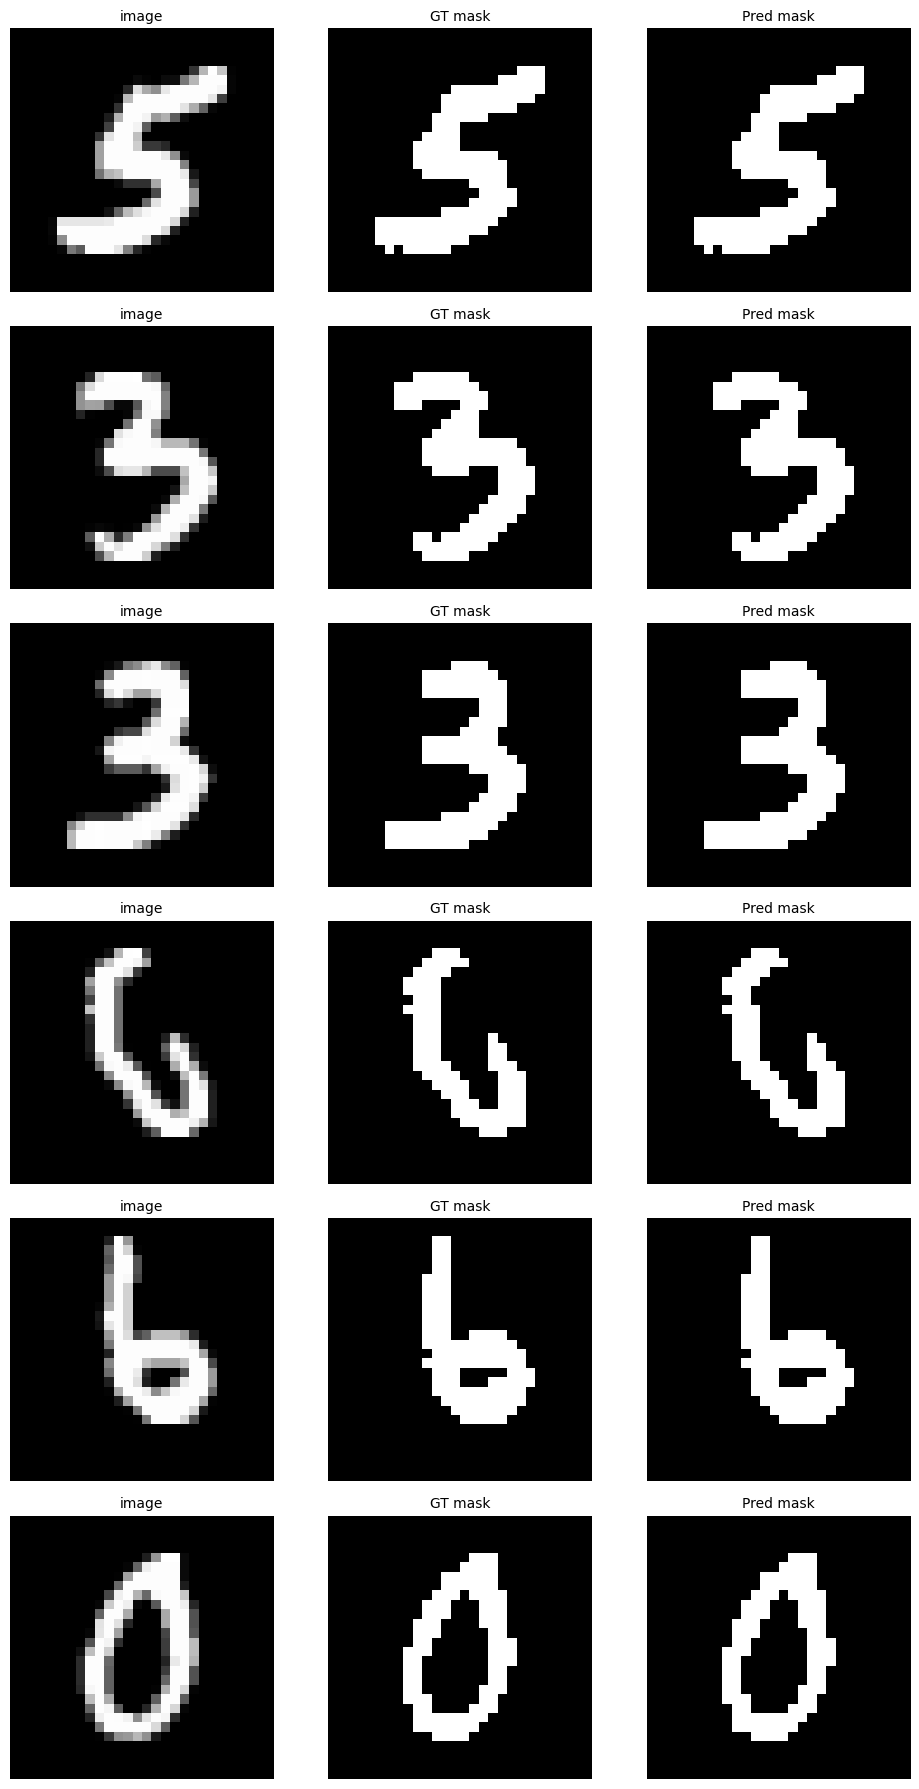

In [ ]:
# Q2: Foreground extraction on Q1(a) with IoU evaluation

import os, math, random
from pathlib import Path
import numpy as np
import cv2 as cv
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

# ---------- Paths ----------
LOCAL = Path("/content/ee604/q1a_pairs")
DRIVE = Path("/content/drive/MyDrive/ee604/q1a_pairs")
ROOT  = LOCAL if LOCAL.exists() else DRIVE
TRDIR = ROOT / "train"
TEDIR = ROOT / "test"
assert TRDIR.exists() and TEDIR.exists(), f"Q1(a) not found at {ROOT}"

# ---------- Dataset ----------
class Q1aPairs(Dataset):
    def __init__(self, root, augment=False):
        self.root = Path(root)
        self.imgs = sorted(self.root.glob("*_img.png"))
        self.augment = augment

    def __len__(self): return len(self.imgs)

    def __getitem__(self, idx):
        ip = self.imgs[idx]
        mp = ip.with_name(ip.name.replace("_img.png", "_mask.png"))
        img = cv.imread(str(ip), cv.IMREAD_GRAYSCALE)       # (28,28) uint8
        msk = cv.imread(str(mp), cv.IMREAD_GRAYSCALE)       # (28,28) uint8 {0,255}

        # light augment (optional)
        if self.augment and random.random() < 0.5:
            img = np.ascontiguousarray(np.fliplr(img))
            msk = np.ascontiguousarray(np.fliplr(msk))
        if self.augment and random.random() < 0.5:
            img = np.ascontiguousarray(np.flipud(img))
            msk = np.ascontiguousarray(np.flipud(msk))

        # to tensors in [0,1]
        img = torch.from_numpy(img).float().unsqueeze(0) / 255.0       # (1,28,28)
        msk = torch.from_numpy((msk > 0).astype(np.float32)).unsqueeze(0)  # (1,28,28) {0,1}
        return img, msk

# ---------- Model: U-Net  ----------
class DoubleConv(nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(c_in, c_out, 3, padding=1), nn.BatchNorm2d(c_out), nn.ReLU(inplace=True),
            nn.Conv2d(c_out, c_out, 3, padding=1), nn.BatchNorm2d(c_out), nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.block(x)

class TinyUNet(nn.Module):
    def __init__(self, base=16):
        super().__init__()
        self.d1 = DoubleConv(1, base)          # 28x28
        self.p1 = nn.MaxPool2d(2)              # 14x14
        self.d2 = DoubleConv(base, base*2)     # 14x14
        self.p2 = nn.MaxPool2d(2)              # 7x7
        self.b  = DoubleConv(base*2, base*4)   # 7x7

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # 14x14
        self.u2  = DoubleConv(base*4 + base*2, base*2)
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # 28x28
        self.u1  = DoubleConv(base*2 + base, base)

        self.out = nn.Conv2d(base, 1, kernel_size=1)

    def forward(self, x):
        x1 = self.d1(x)
        x2 = self.d2(self.p1(x1))
        xb = self.b(self.p2(x2))
        x  = self.up2(xb); x = self.u2(torch.cat([x, x2], dim=1))
        x  = self.up1(x);  x = self.u1(torch.cat([x, x1], dim=1))
        return self.out(x)   # logits

# ---------- IoU metric ----------
@torch.no_grad()
def iou_score(pred_logits, target, thr=0.5, eps=1e-7):
    # pred_logits: (B,1,H,W), target: (B,1,H,W) in {0,1}
    pred = (torch.sigmoid(pred_logits) > thr).float()
    inter = (pred * target).sum(dim=(1,2,3))
    union = (pred + target - pred*target).sum(dim=(1,2,3))
    iou = (inter + eps) / (union + eps)
    return iou.mean().item()

# ---------- Training ----------
def train_q2(epochs=40, batch_size=64, lr=1e-3, weight_decay=1e-5, base_ch=16, aug=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ds_tr = Q1aPairs(TRDIR, augment=aug)
    ds_te = Q1aPairs(TEDIR, augment=False)
    dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    dl_te = DataLoader(ds_te, batch_size=1024, shuffle=False, num_workers=2, pin_memory=True)

    model = TinyUNet(base=base_ch).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    # BCEWithLogits is perfect for foreground extraction
    loss_fn = nn.BCEWithLogitsLoss()

    best_iou, best_state = 0.0, None
    for ep in range(1, epochs+1):
        model.train()
        running = 0.0
        for x, y in tqdm(dl_tr, desc=f"Epoch {ep}/{epochs}", leave=False):
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            logits = model(x)
            loss = loss_fn(logits, y)
            loss.backward()
            opt.step()
            running += loss.item() * x.size(0)
        tr_loss = running / len(ds_tr)

        # eval IoU
        model.eval()
        ious = []
        with torch.no_grad():
            for x, y in dl_te:
                x = x.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True)
                logits = model(x)
                ious.append(iou_score(logits, y))
        te_iou = float(np.mean(ious))

        print(f"[ep {ep}] train_loss={tr_loss:.4f}  test_IoU={te_iou:.4f}")
        if te_iou > best_iou:
            best_iou, best_state = te_iou, {k:v.cpu() for k,v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict(best_state)
    print(f"Best test IoU: {best_iou:.4f}")
    return model, best_iou

model, best_iou = train_q2()

# ---------- Quick visual sanity check ----------
@torch.no_grad()
def viz_samples(model, k=6):
    device = next(model.parameters()).device
    ds = Q1aPairs(TEDIR, augment=False)
    idxs = random.sample(range(len(ds)), k=min(k, len(ds)))
    ims, gts, prs = [], [], []
    for i in idxs:
        img, msk = ds[i]
        logit = model(img.unsqueeze(0).to(device))
        pred = (torch.sigmoid(logit).cpu().squeeze(0) > 0.5).float()
        im = (img.squeeze(0).numpy()*255).astype(np.uint8)
        gt = (msk.squeeze(0).numpy()*255).astype(np.uint8)
        pr = (pred.squeeze(0).numpy()*255).astype(np.uint8)

        def overlay(gray, mask, color=(0,255,0), alpha=0.35):
            rgb = cv.cvtColor(gray, cv.COLOR_GRAY2RGB)
            col = np.zeros_like(rgb); col[mask>0] = color
            return cv.addWeighted(rgb, 1.0, col, alpha, 0)

        ims += [im, gt, pr]
        gts += ["image", "GT mask", "Pred mask"]
    # show grid
    cols = 3
    rows = math.ceil(len(ims)/cols)
    plt.figure(figsize=(10, 3*rows))
    for i, im in enumerate(ims):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(im, cmap='gray')
        ax.set_title(gts[i], fontsize=10)
        ax.axis('off')
    plt.tight_layout(); plt.show()

viz_samples(model, k=6)


In [ ]:
# === Save the best Q2 model checkpoint (run AFTER training) ===
import torch, json, time
from pathlib import Path

# Paths
SAVE_LOCAL = Path("/content/ee604/models"); SAVE_LOCAL.mkdir(parents=True, exist_ok=True)
SAVE_DRIVE = Path("/content/drive/MyDrive/ee604/models"); SAVE_DRIVE.mkdir(parents=True, exist_ok=True)

# Filenames with timestamp
ts = time.strftime("%Y%m%d_%H%M%S")
ckpt_name = f"q2_unet_best_{ts}.pth"
meta_name = f"q2_unet_best_{ts}.json"

# Build a lightweight checkpoint (state_dict + metrics + minimal config)
ckpt = {
    "state_dict": {k: v.cpu() for k, v in model.state_dict().items()},  # ensure CPU tensors
    "best_iou": float(best_iou),
    "config": {
        "arch": "TinyUNet",
        "base_ch": 16,       # change if you trained with a different base_ch
        "img_size": [28, 28],
        "loss": "BCEWithLogitsLoss",
        "metric": "IoU (binary)",
        "train_batch_size": 64,
        "test_batch_size": 1024,
        "epochs": 40,
        "lr": 1e-3,
        "weight_decay": 1e-5,
        "augment": True
    }
}

# Save to local
torch.save(ckpt, SAVE_LOCAL / ckpt_name)
with open(SAVE_LOCAL / meta_name, "w") as f:
    json.dump({"best_iou": ckpt["best_iou"], "ckpt": ckpt_name, **ckpt["config"]}, f, indent=2)

# Also save to Drive
torch.save(ckpt, SAVE_DRIVE / ckpt_name)
with open(SAVE_DRIVE / meta_name, "w") as f:
    json.dump({"best_iou": ckpt["best_iou"], "ckpt": ckpt_name, **ckpt["config"]}, f, indent=2)

print("Saved best checkpoint:")
print(" Local:", SAVE_LOCAL / ckpt_name)
print(" Drive:", SAVE_DRIVE / ckpt_name)
print("Best test IoU:", ckpt["best_iou"])


Saved best checkpoint:
 Local: /content/ee604/models/q2_unet_best_20251112_185057.pth
 Drive: /content/drive/MyDrive/ee604/models/q2_unet_best_20251112_185057.pth
Best test IoU: 0.9967655420303345


In [ ]:
import os, math, random, shutil
from pathlib import Path
import numpy as np
import cv2 as cv
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import csv

# ---------------- Paths ----------------
LOCAL_Q1B = Path("/content/ee604/q1b_pairs")
DRIVE_Q1B = Path("/content/drive/MyDrive/ee604/q1b_pairs")
Q1B_ROOT  = LOCAL_Q1B if LOCAL_Q1B.exists() else DRIVE_Q1B
TRDIR = Q1B_ROOT / "train"
TEDIR = Q1B_ROOT / "test"
assert (TRDIR / "manifest.csv").exists() and (TEDIR / "manifest.csv").exists(), "Q1(b) not found."

# Where to save best model
LOCAL_MODEL_DIR = Path("/content/ee604/models"); LOCAL_MODEL_DIR.mkdir(parents=True, exist_ok=True)
BEST_LOCAL = LOCAL_MODEL_DIR / "q3_best.pt"
DRIVE_MODEL_DIR = Path("/content/drive/MyDrive/ee604/models"); DRIVE_MODEL_DIR.mkdir(parents=True, exist_ok=True)
BEST_DRIVE = DRIVE_MODEL_DIR / BEST_LOCAL.name

# ---------------- Dataset ----------------
class Q1bCirclization(Dataset):
    """
    Returns:
      img  : float tensor (1,28,28) in [0,1]
      cmsk : float tensor (1,28,28) in {0,1}
      y    : long scalar in [0..9]
    """
    def __init__(self, split_dir: Path):
        self.rows = []
        man = split_dir / "manifest.csv"
        with open(man, newline="") as f:
            r = csv.reader(f)
            header = next(r, None)  # ["img_path","circle_mask_path","label"]
            for row in r:
                self.rows.append((row[0], row[1], int(row[2])))

    def __len__(self): return len(self.rows)

    def __getitem__(self, idx):
        p_img, p_cmsk, y = self.rows[idx]
        img  = cv.imread(p_img,  cv.IMREAD_GRAYSCALE)
        cmsk = cv.imread(p_cmsk, cv.IMREAD_GRAYSCALE)
        # to tensors
        img_t  = torch.from_numpy(img).float().unsqueeze(0) / 255.0          # (1,28,28)
        cmsk_t = torch.from_numpy((cmsk > 0).astype(np.float32)).unsqueeze(0)# (1,28,28)
        y_t    = torch.tensor(y, dtype=torch.long)
        return img_t, cmsk_t, y_t

# ---------------- Model (shared encoder + 2 heads) ----------------
class DoubleConv(nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(c_in, c_out, 3, padding=1), nn.BatchNorm2d(c_out), nn.ReLU(inplace=True),
            nn.Conv2d(c_out, c_out, 3, padding=1), nn.BatchNorm2d(c_out), nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class CirclizationNet(nn.Module):
    """
    Shared encoder -> (a) class head, (b) mask head
    Small UNet-ish decoder for mask; global pooled features for class.
    """
    def __init__(self, base=16, num_classes=10):
        super().__init__()
        # encoder
        self.d1 = DoubleConv(1, base)          # 28x28
        self.p1 = nn.MaxPool2d(2)              # 14x14
        self.d2 = DoubleConv(base, base*2)     # 14x14
        self.p2 = nn.MaxPool2d(2)              # 7x7
        self.b  = DoubleConv(base*2, base*4)   # 7x7

        # decoder for mask
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False) # 14x14
        self.u2  = DoubleConv(base*4 + base*2, base*2)
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False) # 28x28
        self.u1  = DoubleConv(base*2 + base, base)
        self.mask_out = nn.Conv2d(base, 1, kernel_size=1)  # logits

        # class head
        self.cls_pool = nn.AdaptiveAvgPool2d((1,1))
        self.cls_fc   = nn.Linear(base*4, num_classes)

    def forward(self, x):
        x1 = self.d1(x)              # 28x28
        x2 = self.d2(self.p1(x1))    # 14x14
        xb = self.b(self.p2(x2))     # 7x7

        # class path
        g = self.cls_pool(xb).flatten(1)     # (B, base*4)
        logits_cls = self.cls_fc(g)          # (B,10)

        # mask path
        y = self.up2(xb); y = self.u2(torch.cat([y, x2], dim=1))
        y = self.up1(y);  y = self.u1(torch.cat([y, x1], dim=1))
        logits_mask = self.mask_out(y)       # (B,1,28,28)
        return logits_cls, logits_mask

# ---------------- Metrics ----------------
@torch.no_grad()
def gated_iou(pred_cls_logits, pred_mask_logits, y_true, m_true, thr=0.5, eps=1e-7):
    """
    Gated IoU: IoU is 0 if predicted class != y_true; else IoU(mask_pred, m_true).
    """
    # class predictions
    y_pred = pred_cls_logits.argmax(dim=1)  # (B,)
    cls_ok = (y_pred == y_true).float()     # (B,)

    # mask predictions
    m_pred = (torch.sigmoid(pred_mask_logits) > thr).float()  # (B,1,H,W)
    inter = (m_pred * m_true).sum(dim=(1,2,3))
    union = (m_pred + m_true - m_pred*m_true).sum(dim=(1,2,3))
    iou = (inter + eps) / (union + eps)                       # (B,)

    # gate by class correctness
    gated = iou * cls_ok
    return gated.mean().item()

# ---------------- Train/Eval ----------------
def train_q3(epochs=8, batch_size=256, lr=1e-3, wd=1e-5, base_ch=16, lambda_mask=1.0, lambda_cls=1.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ds_tr = Q1bCirclization(TRDIR)
    ds_te = Q1bCirclization(TEDIR)

    # show load progress once
    print(f"Train samples: {len(ds_tr)} | Test samples: {len(ds_te)}")

    dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
    dl_te = DataLoader(ds_te, batch_size=1024,     shuffle=False, num_workers=2, pin_memory=True)

    model = CirclizationNet(base=base_ch).to(device)
    opt   = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    loss_mask = nn.BCEWithLogitsLoss()
    loss_cls  = nn.CrossEntropyLoss()

    best_iou, best_state = 0.0, None

    for ep in range(1, epochs+1):
        model.train()
        running = 0.0
        pbar = tqdm(dl_tr, desc=f"Epoch {ep}/{epochs} [train]")
        for img, cmsk, y in pbar:
            img = img.to(device, non_blocking=True)
            cmsk = cmsk.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            opt.zero_grad(set_to_none=True)
            logits_cls, logits_mask = model(img)
            L = lambda_mask * loss_mask(logits_mask, cmsk) + lambda_cls * loss_cls(logits_cls, y)
            L.backward()
            opt.step()
            running += L.item() * img.size(0)
            pbar.set_postfix(loss=f"{L.item():.4f}")

        tr_loss = running / len(ds_tr)

        # eval with gated IoU
        model.eval()
        ious = []
        pbar = tqdm(dl_te, desc=f"Epoch {ep}/{epochs} [eval]")
        with torch.no_grad():
            for img, cmsk, y in pbar:
                img = img.to(device, non_blocking=True)
                cmsk = cmsk.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True)
                logits_cls, logits_mask = model(img)
                giou = gated_iou(logits_cls, logits_mask, y, cmsk, thr=0.5)
                ious.append(giou)
                pbar.set_postfix(gIoU=f"{giou:.4f}")
        te_giou = float(np.mean(ious))
        print(f"[ep {ep}] train_loss={tr_loss:.4f}  test_gated_IoU={te_giou:.4f}")

        if te_giou > best_iou:
            best_iou, best_state = te_giou, {k: v.cpu() for k, v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict(best_state)
        torch.save(model.state_dict(), BEST_LOCAL)
        # copy to Drive
        shutil.copy2(BEST_LOCAL, BEST_DRIVE)
        print(f"Saved best model (gIoU={best_iou:.4f}) to:\n- Local: {BEST_LOCAL}\n- Drive: {BEST_DRIVE}")
    else:
        print("No improvement recorded.")

    return model, best_iou

# -------- run training --------
model_q3, best_giou = train_q3(
    epochs=15,
    batch_size=256,
    lr=1e-3,
    wd=1e-5,
    base_ch=16,
    lambda_mask=1.0,
    lambda_cls=1.0
)


Train samples: 60000 | Test samples: 10000


Epoch 1/15 [eval]: 100%|██████████| 10/10 [00:40<00:00,  4.08s/it, gIoU=0.8956]


[ep 1] train_loss=0.7450  test_gated_IoU=0.8886


Epoch 2/15 [eval]: 100%|██████████| 10/10 [00:28<00:00,  2.80s/it, gIoU=0.9105]


[ep 2] train_loss=0.2006  test_gated_IoU=0.9056


Epoch 3/15 [eval]: 100%|██████████| 10/10 [00:26<00:00,  2.62s/it, gIoU=0.9136]


[ep 3] train_loss=0.1596  test_gated_IoU=0.9093


Epoch 4/15 [eval]: 100%|██████████| 10/10 [00:28<00:00,  2.87s/it, gIoU=0.9118]


[ep 4] train_loss=0.1419  test_gated_IoU=0.9122


Epoch 5/15 [eval]: 100%|██████████| 10/10 [00:26<00:00,  2.65s/it, gIoU=0.9164]


[ep 5] train_loss=0.1311  test_gated_IoU=0.9107


Epoch 6/15 [eval]: 100%|██████████| 10/10 [00:27<00:00,  2.76s/it, gIoU=0.9194]


[ep 6] train_loss=0.1249  test_gated_IoU=0.9186


Epoch 7/15 [eval]: 100%|██████████| 10/10 [00:28<00:00,  2.83s/it, gIoU=0.9241]


[ep 7] train_loss=0.1176  test_gated_IoU=0.9175


Epoch 8/15 [eval]: 100%|██████████| 10/10 [00:27<00:00,  2.79s/it, gIoU=0.9223]


[ep 8] train_loss=0.1149  test_gated_IoU=0.9157


Epoch 9/15 [eval]: 100%|██████████| 10/10 [00:27<00:00,  2.78s/it, gIoU=0.9220]


[ep 9] train_loss=0.1118  test_gated_IoU=0.9188


Epoch 10/15 [eval]: 100%|██████████| 10/10 [00:27<00:00,  2.73s/it, gIoU=0.9227]


[ep 10] train_loss=0.1085  test_gated_IoU=0.9186


Epoch 11/15 [eval]: 100%|██████████| 10/10 [00:27<00:00,  2.70s/it, gIoU=0.9235]


[ep 11] train_loss=0.1053  test_gated_IoU=0.9226


Epoch 12/15 [eval]: 100%|██████████| 10/10 [00:27<00:00,  2.75s/it, gIoU=0.9272]


[ep 12] train_loss=0.1027  test_gated_IoU=0.9235


Epoch 13/15 [eval]: 100%|██████████| 10/10 [00:27<00:00,  2.78s/it, gIoU=0.9272]


[ep 13] train_loss=0.1015  test_gated_IoU=0.9245


Epoch 14/15 [eval]: 100%|██████████| 10/10 [00:28<00:00,  2.89s/it, gIoU=0.9275]


[ep 14] train_loss=0.0990  test_gated_IoU=0.9222


Epoch 15/15 [eval]: 100%|██████████| 10/10 [00:27<00:00,  2.78s/it, gIoU=0.9291]


[ep 15] train_loss=0.0974  test_gated_IoU=0.9250
Saved best model (gIoU=0.9250) to:
- Local: /content/ee604/models/q3_best.pt
- Drive: /content/drive/MyDrive/ee604/models/q3_best.pt


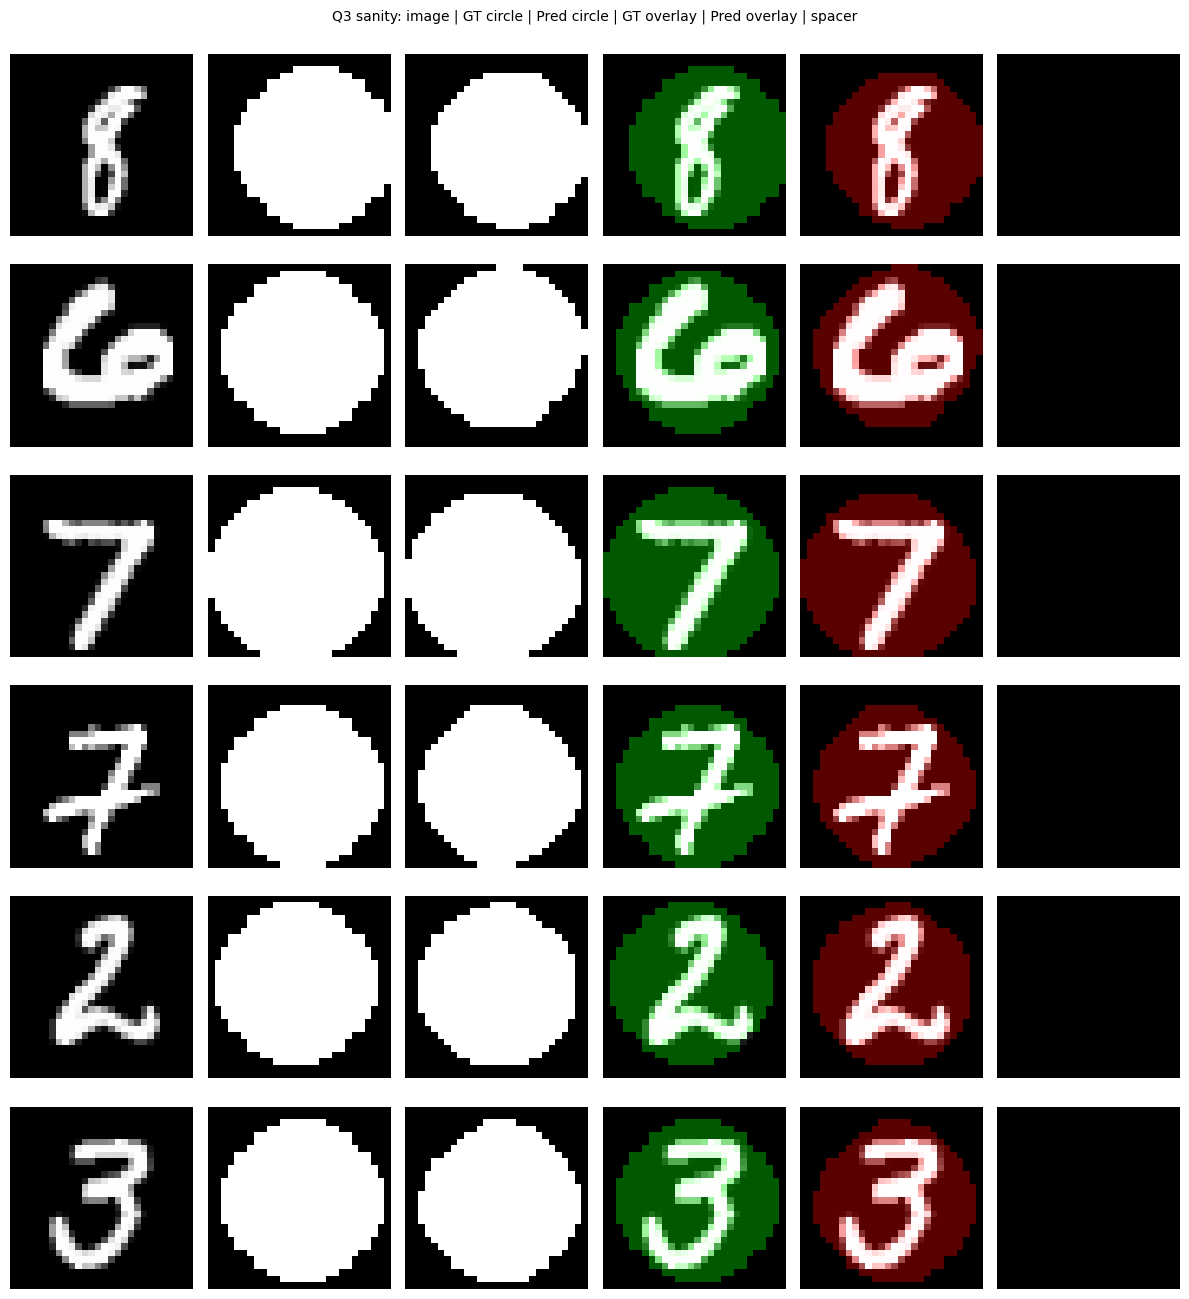

In [ ]:
# -------- optional: quick sanity viz on a few test samples --------
@torch.no_grad()
def viz_q3(model, k=6):
    device = next(model.parameters()).device
    ds = Q1bCirclization(TEDIR)
    idxs = random.sample(range(len(ds)), k=min(k, len(ds)))
    import matplotlib.pyplot as plt
    tiles = []
    for i in idxs:
        img, cm, y = ds[i]
        img_b = img.unsqueeze(0).to(device)
        logits_cls, logits_mask = model(img_b)
        yhat = logits_cls.argmax(dim=1).item()
        pmask = torch.sigmoid(logits_mask).cpu()
        pmask = (pmask[0, 0] > 0.5).numpy().astype(np.uint8) * 255
        im = (img.squeeze(0).numpy()*255).astype(np.uint8)

        # overlays
        def overlay(gray, mask, color=(255,0,0), alpha=0.35):
            rgb = cv.cvtColor(gray, cv.COLOR_GRAY2RGB)
            col = np.zeros_like(rgb); col[mask>0] = color
            return cv.addWeighted(rgb, 1.0, col, alpha, 0)

        tiles += [im, cm.squeeze(0).numpy().astype(np.uint8)*255, pmask,
                  overlay(im, cm.squeeze(0).numpy().astype(np.uint8)*255, (0,255,0), 0.35),
                  overlay(im, pmask, (255,0,0), 0.35),
                  np.uint8(np.ones((28,28))*0)]  # spacer

    cols = 6
    rows = math.ceil(len(tiles)/cols)
    plt.figure(figsize=(12, rows*2.2))
    for i, im in enumerate(tiles):
        ax = plt.subplot(rows, cols, i+1)
        if im.ndim == 2:
            ax.imshow(im, cmap='gray', vmin=0, vmax=255)
        else:
            ax.imshow(im)
        ax.axis('off')
    plt.suptitle("Q3 sanity: image | GT circle | Pred circle | GT overlay | Pred overlay | spacer", y=0.99, fontsize=10)
    plt.tight_layout(); plt.show()

viz_q3(model_q3, k=6)

In [ ]:
import os, gc, ctypes, shutil, random
from pathlib import Path
import numpy as np
import cv2 as cv
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

LOCAL_Q1C = Path("/content/ee604/q1c_semseg")
DRIVE_Q1C = Path("/content/drive/MyDrive/ee604/q1c_semseg")
Q1C_ROOT  = LOCAL_Q1C if LOCAL_Q1C.exists() else DRIVE_Q1C
TR_IMG, TR_LBL = Q1C_ROOT/"train/images", Q1C_ROOT/"train/labels"
TE_IMG, TE_LBL = Q1C_ROOT/"test/images",  Q1C_ROOT/"test/labels"

class Q1c(Dataset):
    def __init__(self, img_dir, lbl_dir, limit=None, augment=False):
        self.imgs = sorted(Path(img_dir).glob("*.png"))
        if limit is not None: self.imgs = self.imgs[:int(limit)]
        self.lbl_dir = Path(lbl_dir); self.augment = augment
    def __len__(self): return len(self.imgs)
    def __getitem__(self, idx):
        ip = self.imgs[idx]; lp = self.lbl_dir / ip.name
        img = cv.imread(str(ip), cv.IMREAD_GRAYSCALE)
        lbl = cv.imread(str(lp), cv.IMREAD_GRAYSCALE).copy()
        lbl[lbl == 255] = 10  # map ignore to class 10 (background)
        if self.augment and random.random() < 0.5:
            img = np.ascontiguousarray(np.fliplr(img)); lbl = np.ascontiguousarray(np.fliplr(lbl))
        if self.augment and random.random() < 0.5:
            img = np.ascontiguousarray(np.flipud(img)); lbl = np.ascontiguousarray(np.flipud(lbl))
        img_t = torch.from_numpy(img).float().unsqueeze(0) / 255.0
        lbl_t = torch.from_numpy(lbl.astype(np.int64))
        return img_t, lbl_t

class DoubleConv(nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(c_in, c_out, 3, padding=1), nn.BatchNorm2d(c_out), nn.ReLU(inplace=True),
            nn.Conv2d(c_out, c_out, 3, padding=1), nn.BatchNorm2d(c_out), nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class LiteUNetMC(nn.Module):
    def __init__(self, base=24, n_classes=10):
        super().__init__()
        self.d1 = DoubleConv(1, base); self.p1 = nn.MaxPool2d(2)
        self.d2 = DoubleConv(base, base*2); self.p2 = nn.MaxPool2d(2)
        self.b  = DoubleConv(base*2, base*4)
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.u2  = DoubleConv(base*4 + base*2, base*2)
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.u1  = DoubleConv(base*2 + base, base)
        self.out = nn.Conv2d(base, n_classes, 1)
    def forward(self, x):
        x1 = self.d1(x); x2 = self.d2(self.p1(x1)); xb = self.b(self.p2(x2))
        y  = self.up2(xb); y = self.u2(torch.cat([y, x2], dim=1))
        y  = self.up1(y);  y = self.u1(torch.cat([y, x1], dim=1))
        return self.out(y)

@torch.no_grad()
def dice_mc(logits, target, eps=1e-7):
    pred = logits.argmax(1)
    dices = []
    for c in range(11):
        p = (pred == c); t = (target == c)
        if p.any() or t.any():
            inter = (p & t).sum().item()
            denom = p.sum().item() + t.sum().item()
            dices.append((2*inter + eps) / (denom + eps))
    return float(np.mean(dices)) if dices else 0.0

def train_q4(
    epochs=10, base_ch=24, lr=1e-3, wd=1e-5,
    batch_size=1024, limit_train=None, limit_test=None
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.backends.cudnn.benchmark = True
    use_amp = torch.cuda.is_available()

    ds_tr = Q1c(TR_IMG, TR_LBL, limit=limit_train, augment=True)
    ds_te = Q1c(TE_IMG, TE_LBL, limit=limit_test,  augment=False)
    print(f"Train={len(ds_tr)}  Test={len(ds_te)}")

    dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True,
                       num_workers=0, pin_memory=False, persistent_workers=False)
    dl_te = DataLoader(ds_te, batch_size=1024, shuffle=False,
                       num_workers=0, pin_memory=False, persistent_workers=False)

    model = LiteUNetMC(base=base_ch, n_classes=11).to(device).to(memory_format=torch.channels_last)
    loss_ce = nn.CrossEntropyLoss()  # no ignore index
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    scaler = torch.amp.GradScaler('cuda', enabled=use_amp)

    LOCAL_MODEL_DIR = Path("/content/ee604/models"); LOCAL_MODEL_DIR.mkdir(parents=True, exist_ok=True)
    DRIVE_MODEL_DIR = Path("/content/drive/MyDrive/ee604/models"); DRIVE_MODEL_DIR.mkdir(parents=True, exist_ok=True)
    BEST_LOCAL  = LOCAL_MODEL_DIR / "q4_semseg_best_11cls.pt"
    FINAL_LOCAL = LOCAL_MODEL_DIR / "q4_semseg_final_11cls.pt"
    BEST_DRIVE  = DRIVE_MODEL_DIR / BEST_LOCAL.name
    FINAL_DRIVE = DRIVE_MODEL_DIR / FINAL_LOCAL.name

    best_dice = -1.0

    for ep in range(1, epochs+1):
        model.train()
        run_loss, seen = 0.0, 0
        for img, lbl in tqdm(dl_tr, desc=f"Epoch {ep}/{epochs} [train]"):
            img = img.to(device, memory_format=torch.channels_last)
            lbl = lbl.to(device)

            opt.zero_grad(set_to_none=True)
            with torch.amp.autocast('cuda', enabled=use_amp):
                logits = model(img)
                L = loss_ce(logits, lbl)
            scaler.scale(L).backward()
            scaler.step(opt); scaler.update()

            bs = img.size(0); run_loss += L.item() * bs; seen += bs
            del img, lbl, logits, L
            if torch.cuda.is_available(): torch.cuda.empty_cache()

        tr_loss = run_loss / max(1, seen)

        # eval
        model.eval()
        dice_sum = 0.0; n_batches = 0
        with torch.no_grad():
            for img, lbl in tqdm(dl_te, desc=f"Epoch {ep}/{epochs} [eval]"):
                img = img.to(device, memory_format=torch.channels_last)
                lbl = lbl.to(device)
                with torch.amp.autocast('cuda', enabled=use_amp):
                    logits = model(img)
                dice_sum += dice_mc(logits, lbl)
                n_batches += 1
                del img, lbl, logits
        te_dice = dice_sum / max(1, n_batches)
        print(f"[ep {ep}] train_loss={tr_loss:.4f}  test_Dice(11cls)={te_dice:.4f}")

        if te_dice > best_dice:
            best_dice = te_dice
            torch.save(model.state_dict(), BEST_LOCAL)
            shutil.copy2(BEST_LOCAL, BEST_DRIVE)
            print("NEW BEST →", BEST_DRIVE)

    torch.save(model.state_dict(), FINAL_LOCAL)
    shutil.copy2(FINAL_LOCAL, FINAL_DRIVE)
    print("FINAL →", FINAL_DRIVE)
    return model, best_dice

model_q4_11, best_dice = train_q4()
print("Best Dice (11 classes):", best_dice)

Train=250000  Test=10000


Epoch 1/10 [eval]: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


[ep 1] train_loss=0.7462  test_Dice(11cls)=0.8666
NEW BEST → /content/drive/MyDrive/ee604/models/q4_semseg_best_11cls.pt


Epoch 2/10 [eval]: 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


[ep 2] train_loss=0.0792  test_Dice(11cls)=0.9091
NEW BEST → /content/drive/MyDrive/ee604/models/q4_semseg_best_11cls.pt


Epoch 3/10 [eval]: 100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


[ep 3] train_loss=0.0316  test_Dice(11cls)=0.9588
NEW BEST → /content/drive/MyDrive/ee604/models/q4_semseg_best_11cls.pt


Epoch 4/10 [eval]: 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


[ep 4] train_loss=0.0194  test_Dice(11cls)=0.9661
NEW BEST → /content/drive/MyDrive/ee604/models/q4_semseg_best_11cls.pt


Epoch 5/10 [eval]: 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]


[ep 5] train_loss=0.0138  test_Dice(11cls)=0.9645


Epoch 6/10 [eval]: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]


[ep 6] train_loss=0.0105  test_Dice(11cls)=0.9496


Epoch 7/10 [eval]: 100%|██████████| 10/10 [00:03<00:00,  2.66it/s]


[ep 7] train_loss=0.0085  test_Dice(11cls)=0.9765
NEW BEST → /content/drive/MyDrive/ee604/models/q4_semseg_best_11cls.pt


Epoch 8/10 [eval]: 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


[ep 8] train_loss=0.0070  test_Dice(11cls)=0.9562


Epoch 9/10 [eval]: 100%|██████████| 10/10 [00:04<00:00,  2.36it/s]


[ep 9] train_loss=0.0061  test_Dice(11cls)=0.9675


Epoch 10/10 [eval]: 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


[ep 10] train_loss=0.0052  test_Dice(11cls)=0.9660
FINAL → /content/drive/MyDrive/ee604/models/q4_semseg_final_11cls.pt
Best Dice (11 classes): 0.9765453269441279


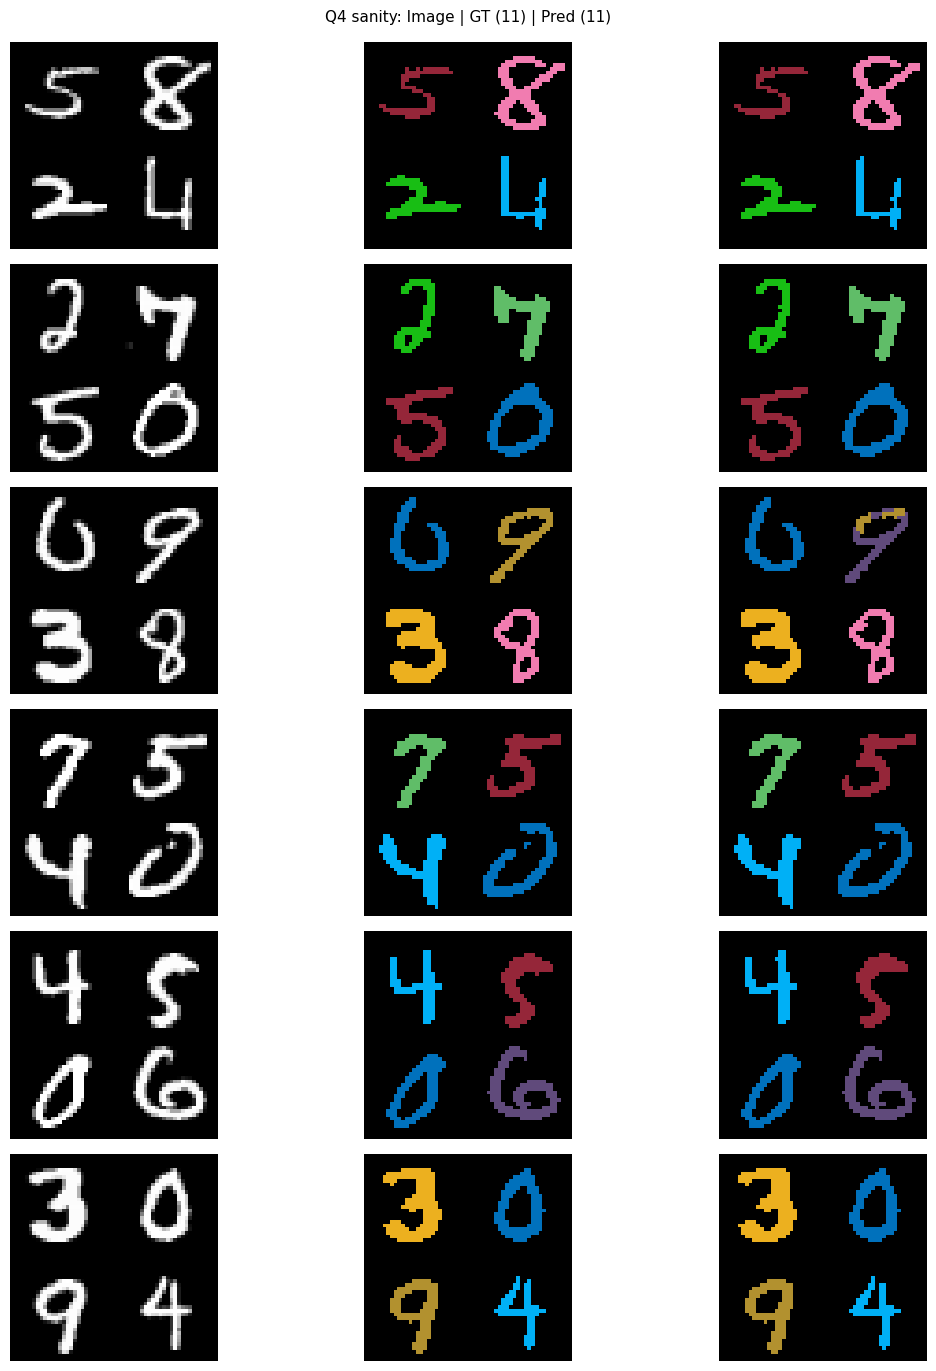

In [ ]:
import math, random
import numpy as np
import torch

@torch.no_grad()
def viz_q4_11(model, k=6, limit=None, title="Q4 sanity: Image | GT (11) | Pred (11)"):
    import matplotlib.pyplot as plt

    ds = Q1c(TE_IMG, TE_LBL, limit=limit, augment=False)
    k = min(k, len(ds))
    if k == 0:
        print("No samples to visualize."); return
    idxs = random.sample(range(len(ds)), k)

    PALETTE = np.array([
        [  0,113,188],  # 0
        [216, 82, 24],  # 1
        [ 24,190, 20],  # 2
        [236,176, 31],  # 3
        [  0,176,246],  # 4
        [149, 38, 57],  # 5
        [ 96, 74,123],  # 6
        [ 96,189,104],  # 7
        [241,124,176],  # 8
        [178,145, 47],  # 9
        [  0,  0,  0],  # 10 = background
    ], dtype=np.uint8)

    def colorize(lbl_np: np.ndarray):
        rgb = np.zeros((lbl_np.shape[0], lbl_np.shape[1], 3), np.uint8)
        for c in range(11):
            rgb[lbl_np == c] = PALETTE[c]
        return rgb

    model.eval()
    device = next(model.parameters()).device
    tiles = []
    for i in idxs:
        img_t, lbl_t = ds[i]                           # img_t: (1,56,56) float[0..1], lbl_t: (56,56) long in {0..10}
        logits = model(img_t.unsqueeze(0).to(device))  # (1,11,56,56)
        pred = logits.argmax(1).cpu().squeeze(0).numpy().astype(np.uint8)

        img_np = (img_t.squeeze(0).numpy() * 255).astype(np.uint8)
        tiles += [img_np, colorize(lbl_t.numpy()), colorize(pred)]

    cols = 3
    rows = math.ceil(len(tiles) / cols)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 2.3 * rows))
    for i, im in enumerate(tiles):
        ax = plt.subplot(rows, cols, i + 1)
        if im.ndim == 2:
            ax.imshow(im, cmap='gray', vmin=0, vmax=255)
        else:
            ax.imshow(im)
        ax.axis('off')
    plt.suptitle(title, y=0.99, fontsize=11)
    plt.tight_layout()
    plt.show()

# call with your trained 11-class model
viz_q4_11(model_q4_11, k=6)
